In [46]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy import stats
import pandas as pd

# Configuración de estilo para gráficos
plt.style.use('seaborn-v0_8-darkgrid')
plt.rcParams['figure.figsize'] = (15, 10)

# ===== CARGAR DATOS =====
print("Cargando datos...")
data1 = np.loadtxt("Final data.dat")

time = data1[:, 0]
observed = data1[:, 1]
calculated=data1[:,2]
reesiduals=data1[:,3]

# Cargar periodos
periodos = np.loadtxt("Periodos 2.per")
# Obtener frecuencias y parámetros de los periodos
freq1 = periodos[0, 0]  # Frecuencia principal (datos observados)
amp1 = periodos[0, 1]   # Amplitud
phase1 = periodos[0, 2] # Fase

freq2 = periodos[1, 0]  # Frecuencia secundaria (residuos)
amp2 = periodos[1, 1]
phase2 = periodos[1, 2]

# Cargar transformadas de Fourier
tf_observed=np.loadtxt("TF.fou")
tf_residuals=np.loadtxt("TF Residuals.fou")
tf_observed_freq=tf_observed[:,0]
tf_observed_amp=tf_observed[:,1]
tf_residuals_freq=tf_residuals[:,0]
tf_residuals_amp=tf_residuals[:,1]

Cargando datos...


In [10]:
# ===== DEFINIR MODELOS =====

def fourier_series(t, mean, A1, f1, phi1, A2, f2, phi2):
    """Modelo de serie de Fourier con 2 componentes"""
    return mean + A1 * np.sin(2*np.pi*f1*t + phi1) + A2 * np.sin(2*np.pi*f2*t + phi2)

def single_fourier(t, mean, A, f, phi):
    """Modelo de Fourier simple"""
    return mean + A * np.sin(2*np.pi*f*t + phi)

def multi_fourier(t, mean, *params):
    """Modelo multi-frecuencia (hasta 5 componentes)"""
    result = mean
    n_components = len(params) // 3
    for i in range(n_components):
        A = params[3*i]
        f = params[3*i + 1]
        phi = params[3*i + 2]
        result += A * np.sin(2*np.pi*f*t + phi)
    return result

In [11]:

# ===== AJUSTE DE CURVAS =====

print("\n" + "="*60)
print("AJUSTANDO MODELOS A LOS DATOS")
print("="*60)

# Modelo 1: Usar parámetros de Period04 (2 frecuencias)
mean_obs = np.mean(observed)
model1 = fourier_series(time, mean_obs, amp1, freq1, phase1, amp2, freq2, phase2)
residuals1 = observed - model1
rms1 = np.sqrt(np.mean(residuals1**2))
r2_1 = 1 - (np.sum(residuals1**2) / np.sum((observed - mean_obs)**2))

print(f"\nModelo 1 (Period04 - 2 frecuencias):")
print(f"  RMS: {rms1:.6f}")
print(f"  R²: {r2_1:.6f}")


AJUSTANDO MODELOS A LOS DATOS

Modelo 1 (Period04 - 2 frecuencias):
  RMS: 0.148341
  R²: 0.132840


In [40]:
print(len(residuals))

1253


In [13]:
# Modelo 3: Encontrar frecuencias dominantes del espectro de Fourier
fft_freq = np.fft.fftfreq(len(time), np.mean(np.diff(time)))
fft_power = np.abs(np.fft.fft(observed - mean_obs))
positive_freq = fft_freq > 0
fft_freq_pos = fft_freq[positive_freq]
fft_power_pos = fft_power[positive_freq]

# Encontrar picos principales
sorted_indices = np.argsort(fft_power_pos)[::-1]
top_freqs = fft_freq_pos[sorted_indices[:3]]

print(f"\nModelo 3 (FFT - frecuencias detectadas):")
print(f"  Top 3 frecuencias: {top_freqs}")


Modelo 3 (FFT - frecuencias detectadas):
  Top 3 frecuencias: [2.03689649 2.08657689 2.23561809]


C:\Users\USER\AppData\Local\Temp\ipykernel_16132\534628247.py:14: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax1.legend()


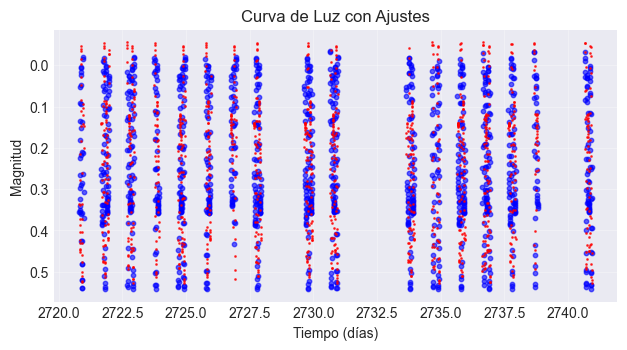

In [30]:


# ===== VISUALIZACIÓN =====

fig = plt.figure(figsize=(16, 12))

# 1. Curva de luz con ajustes
ax1 = plt.subplot(3, 2, 1)
ax1.scatter(time, observed, s=10, alpha=0.6,  color='blue')
#ax1.scatter(time, calculated, alpha=0.7,color="red",s=1)
ax1.scatter(time, model1, alpha=0.7,s=1,color="red")

ax1.set_xlabel('Tiempo (días)')
ax1.set_ylabel('Magnitud')
ax1.set_title('Curva de Luz con Ajustes')
ax1.legend()
ax1.invert_yaxis()
ax1.grid(True, alpha=0.3)

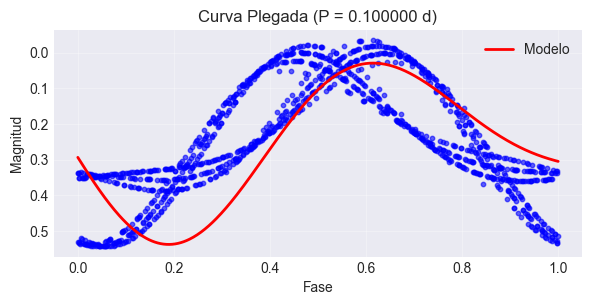

In [ ]:
# 2. Curva de luz plegada con faseeeeee
ax2 = plt.subplot(3, 2, 2)
period1 = 1.0 / freq1
phase = (time % period1) / period1
sorted_idx = np.argsort(phase)
ax2.scatter(phase, observed, s=10, alpha=0.6, color='blue')
phase_model = np.linspace(0, 1, 500)
time_model = phase_model * period1
model_folded = fourier_series(time_model, mean_obs, amp1, freq1, phase1, amp2, freq2, phase2)
ax2.plot(phase_model, model_folded, 'r-', linewidth=2, label='Modelo')
ax2.set_xlabel('Fase')
ax2.set_ylabel('Magnitud')
ax2.set_title(f'Curva Plegada (P = {period1:.6f} d)')
ax2.legend()
ax2.invert_yaxis()
ax2.grid(True, alpha=0.3)

C:\Users\USER\AppData\Local\Temp\ipykernel_16132\166896797.py:10: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax3.legend()


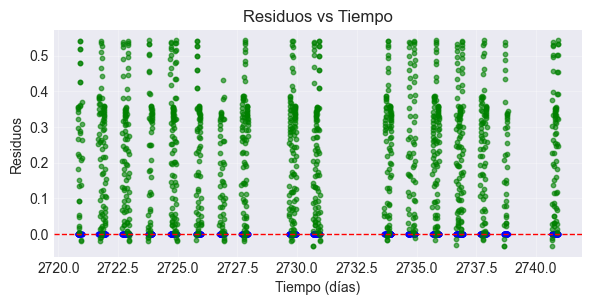

In [55]:
# 3. Residuos vs tiempo
ax3 = plt.subplot(3, 2, 3)
ax3.scatter(time[:1253], residuals, s=10, alpha=0.6, color='blue')
ax3.scatter(time, calculated, s=10, alpha=0.6, color='green')

ax3.axhline(y=0, color='r', linestyle='--', linewidth=1)
ax3.set_xlabel('Tiempo (días)')
ax3.set_ylabel('Residuos')
ax3.set_title('Residuos vs Tiempo')
ax3.legend()
ax3.grid(True, alpha=0.3)


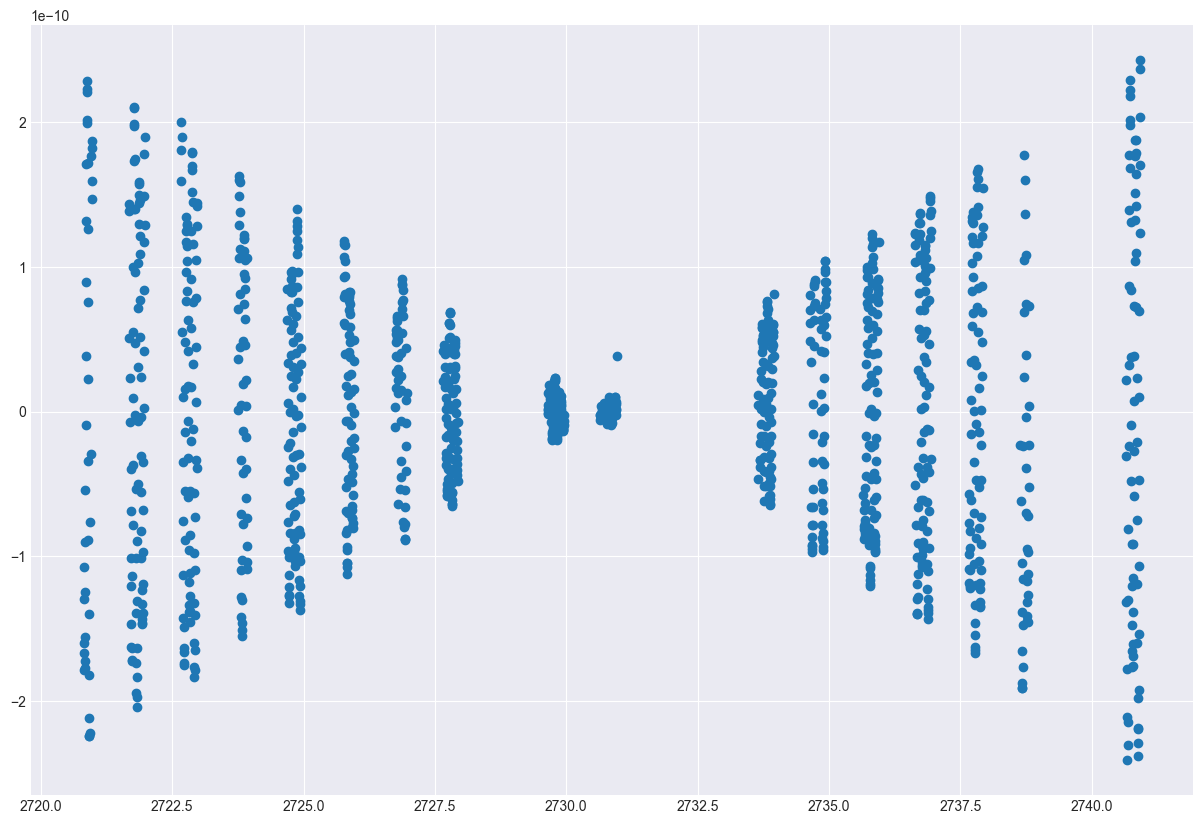

In [57]:
plt.scatter(time[:1253],residuals)

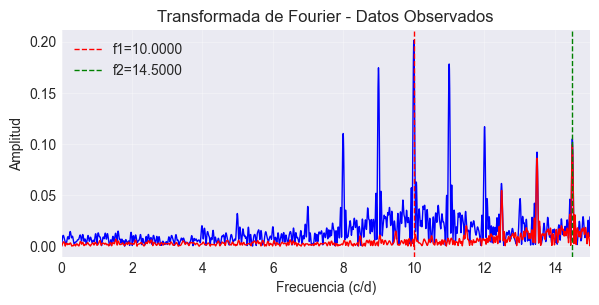

In [61]:
# 4. Transformada de Fourier de datos observados
ax4 = plt.subplot(3, 2, 4)
ax4.plot(tf_observed_freq, tf_observed_amp, 'b-', linewidth=1)
ax4.plot(tf_residuals_freq, tf_residuals_amp, 'r-', linewidth=1)
ax4.axvline(x=freq1, color='r', linestyle='--', linewidth=1, label=f'f1={freq1:.4f}')
ax4.axvline(x=freq2, color='g', linestyle='--', linewidth=1, label=f'f2={freq2:.4f}')
ax4.set_xlabel('Frecuencia (c/d)')
ax4.set_ylabel('Amplitud')
ax4.set_title('Transformada de Fourier - Datos Observados')
ax4.set_xlim(0, 15)
ax4.legend()
ax4.grid(True, alpha=0.3)

In [67]:
# ===== RESUMEN FINAL =====

print("\n" + "="*60)
print("RESUMEN - MEJOR MODELO")
print("="*60)

models_rms = [('Period04 (calculado)', np.sqrt(np.mean(residuals**2))),
              ('Modelo 1 (2 freq)', rms1)]

if popt2 is not None:
    models_rms.append(('Modelo 2 (optimizado)', rms2))

best_model = min(models_rms, key=lambda x: x[1])
print(f"\nMejor modelo: {best_model[0]}")
print(f"RMS mínimo: {best_model[1]:.6f}")

print("\nParámetros recomendados:")
print(f"  Frecuencia principal: {freq1:.6f} c/d (Periodo: {1/freq1:.6f} d)")
print(f"  Frecuencia secundaria: {freq2:.6f} c/d (Periodo: {1/freq2:.6f} d)")
print(f"  Amplitud 1: {amp1:.6f}")
print(f"  Amplitud 2: {amp2:.6f}")

print("\n" + "="*60)
print("Análisis completado exitosamente!")
print("="*60)


RESUMEN - MEJOR MODELO

Mejor modelo: Period04 (calculado)
RMS mínimo: 0.000000

Parámetros recomendados:
  Frecuencia principal: 10.000000 c/d (Periodo: 0.100000 d)
  Frecuencia secundaria: 14.500000 c/d (Periodo: 0.068966 d)
  Amplitud 1: 0.200000
  Amplitud 2: 0.100000

Análisis completado exitosamente!
